# Occupational Employment Statistics
### Description of this survey conducted by the Bureau of Labor Statistics (BLS) can be found [here](https://www.bls.gov/oes/oes_emp.htm)

### The data can be pulled from text files hosted on the BLS site. We will load these tables in Section 1 below

# <font color = blue> Section 1: Setup and file import </font>

In [1]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

# allow plots in jupyter output cells
%matplotlib inline

# allow for all columns to display
pd.set_option('display.max_columns', 100)

### Line of code below copied from [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake VanderPlas

In [2]:
# class to allow for displaying multiple dataframes at once
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

### Here are the tables we will read:
- https://download.bls.gov/pub/time.series/oe/oe.data.1.AllData
    - Contains the series_id along with the metrics for that ID. Think of the series ID as telling you what the metrics correspond to (for example: the series_id can tell you that you are looking at mean wages for management occupations in Texas. The most recent year is 2019
- https://download.bls.gov/pub/time.series/oe/oe.series
    - Contains the information specific to the series_id (e.g., state_code, industry_code)

In [3]:
# read all data
oes_data = pd.read_table('https://download.bls.gov/pub/time.series/oe/oe.data.1.AllData',
                         dtype = {'footnote_codes': str, 'state_code': str, 'series_id': str,
                                  'period': str, 'footnote_codes': str, 'year': str})

In [4]:
# validate dtypes
oes_data.dtypes

series_id                         object
year                              object
period                            object
       value                      object
footnote_codes                    object
dtype: object

In [5]:
# read series attributes
oes_attr = pd.read_table('https://download.bls.gov/pub/time.series/oe/oe.series',
                         dtype = str)

In [6]:
# validate dtypes
oes_attr.dtypes

series_id                         object
seasonal                          object
areatype_code                     object
industry_code                     object
occupation_code                   object
datatype_code                     object
state_code                        object
area_code                         object
sector_code                       object
series_title                      object
footnote_codes                    object
begin_year                        object
begin_period                      object
end_year                          object
end_period                        object
dtype: object

In [7]:
# validate column names
print('oes_data colnames:\n' + str(oes_data.columns))
print('\noes_attr colnames:\n' + str(oes_attr.columns))

oes_data colnames:
Index(['series_id                     ', 'year', 'period', '       value',
       'footnote_codes'],
      dtype='object')

oes_attr colnames:
Index(['series_id                     ', 'seasonal', 'areatype_code',
       'industry_code', 'occupation_code', 'datatype_code', 'state_code',
       'area_code', 'sector_code', 'series_title', 'footnote_codes',
       'begin_year', 'begin_period', 'end_year', 'end_period'],
      dtype='object')


In [8]:
# above we notice that both oes_data and oes_attr have whitespaces
# we remove these whitespaces below
oes_data.columns = oes_data.columns.str.strip()
oes_attr.columns = oes_attr.columns.str.strip()

In [9]:
# display shape attributes of both files
print('oes_data shape: ' + str(oes_data.shape))
print('oes_attr shape: ' + str(oes_attr.shape))

oes_data shape: (5755612, 5)
oes_attr shape: (5755612, 15)


In [10]:
# display first five rows of tables read in above
display(
    'oes_data.head()',
    'oes_attr.head()'
)

oes_data.head()
                        series_id  year period         value footnote_codes
0  OEUM001018000000000000001       2019    A01         66510            NaN
1  OEUM001018000000000000002       2019    A01           3.1            NaN
2  OEUM001018000000000000003       2019    A01         20.08            NaN
3  OEUM001018000000000000004       2019    A01         41760            NaN
4  OEUM001018000000000000005       2019    A01           1.8            NaN

oes_attr.head()
                        series_id seasonal areatype_code industry_code  \
0  OEUM001018000000000000001             U             M        000000   
1  OEUM001018000000000000002             U             M        000000   
2  OEUM001018000000000000003             U             M        000000   
3  OEUM001018000000000000004             U             M        000000   
4  OEUM001018000000000000005             U             M        000000   

  occupation_code datatype_code state_code area_code sector_code  \
0          000000            01         48   0010180      00--01   
1          000000            02         48   0010180      00--01   
2          000000            03         48   0010180      00--01   
3          000000            04         48   0010180      00--01   
4          000000            05         48   0010180      00--01   

                                        series_title footnote_codes  \
0  Employment for All Occupations in All Industri...              1   
1  Employment percent relative standard error for...              3   
2  Hourly mean wage for All Occupations in All In...            NaN   
3  Annual mean wage for All Occupations in All In...              2   
4  Wage percent relative standard error for All O...              3   

  begin_year begin_period end_year end_period  
0       2019          A01     2019        A01  
1       2019          A01     2019        A01  
2       2019          A01     2019        A01  
3       2019          A01     2019        A01  
4       2019          A01     2019        A01

#### Notice how a bunch of the columns in the `oes_attr` table above have codes that are not readily intuitive. As such, we will need various crosswalk files to map codes to values. These crosswalk files are read in below and additional information on each can be found here: https://download.bls.gov/pub/time.series/oe/

In [11]:
# read various crosswalk files below

# industry
xwalk_ind = pd.read_table('https://download.bls.gov/pub/time.series/oe/oe.industry',
                          dtype = {'industry_code': str})

# occupation
xwalk_occ = pd.read_table('https://download.bls.gov/pub/time.series/oe/oe.occupation',
                          dtype = {'occupation_code': str})

# area (e.g., name of metropolitan area or state)
xwalk_area = pd.read_table('https://download.bls.gov/pub/time.series/oe/oe.area',
                           dtype = {'state_code': str, 'area_code': str})

# area type
xwalk_area_type = pd.read_table('https://download.bls.gov/pub/time.series/oe/oe.areatype')

# sector
xwalk_sector = pd.read_table('https://download.bls.gov/pub/time.series/oe/oe.sector')

# data type
xwalk_datatype = pd.read_table('https://download.bls.gov/pub/time.series/oe/oe.datatype',
                               dtype = {'datatype_code': str})

# release
release = pd.read_table('https://download.bls.gov/pub/time.series/oe/oe.release')

# footnote
xwalk_footnote = pd.read_table('https://download.bls.gov/pub/time.series/oe/oe.footnote',
                               dtype = {'footnote_code': str})

# seasonal
xwalk_seasonal = pd.read_table('https://download.bls.gov/pub/time.series/oe/oe.seasonal')

# state names
xwalk_states = pd.read_table('https://download.bls.gov/pub/time.series/sm/sm.state',
                             dtype = str)

In [12]:
# see if any columns from above imported tables have whitespace
print(
    xwalk_ind.columns, xwalk_occ.columns, xwalk_area.columns,
    xwalk_area_type.columns, xwalk_sector.columns, xwalk_datatype.columns,
    xwalk_footnote.columns, xwalk_seasonal.columns, xwalk_states.columns)

Index(['industry_code', 'industry_name', 'display_level', 'selectable',
       'sort_sequence'],
      dtype='object') Index(['occupation_code', 'occupation_name', 'display_level', 'selectable',
       'sort_sequence'],
      dtype='object') Index(['state_code', 'area_code', 'areatype_code', 'area_name'], dtype='object') Index(['areatype_code', 'areatype_name'], dtype='object') Index(['sector_code', 'sector_name'], dtype='object') Index(['datatype_code', 'datatype_name'], dtype='object') Index(['footnote_code', 'footnote_text'], dtype='object') Index(['seasonal_code', 'seasonal_text'], dtype='object') Index(['state_code', 'state_name'], dtype='object')


In [13]:
# display first five rows of all xwalk files
display(
    'xwalk_ind.head()',
    'xwalk_occ.head()',
    'xwalk_area.head()',
    'xwalk_area_type.head()',
    'xwalk_sector.head()',
    'xwalk_datatype.head()',
    'release.head()',
    'xwalk_footnote.head()',
    'xwalk_seasonal.head()',
    'xwalk_states.head()'
)

,industry_code,industry_name,display_level,selectable,sort_sequence
0,000000,"Cross-industry, Private, Federal, State, and L...",0,T,0
1,000001,"Cross-industry, Private Ownership Only",1,T,1
2,11--12,"Sector 11 - Agriculture, Forestry, Fishing and...",2,T,2
3,113000,Forestry and Logging,3,T,3
4,113300,Logging,4,T,4
,occupation_code,occupation_name,display_level,selectable,sort_sequence
0,000000,All Occupations,0,T,0
1,110000,Management Occupations,0,T,1
2,111000,Top Executives,1,T,2
3,111011,Chief Executives,3,T,3


# <font color = 'blue'> Section 1: Apply left joins to create readily usable file

In [14]:
# left join attributes to data
oes_data_2 = pd.merge(oes_data,
                      oes_attr[['series_id', 'seasonal', 'areatype_code', 'industry_code',
                                'occupation_code', 'datatype_code', 'state_code',
                                'area_code', 'sector_code', 'series_title']],
                      on = 'series_id',
                      how = 'left')

oes_data_2.head()

,series_id,year,period,value,footnote_codes,seasonal,areatype_code,industry_code,occupation_code,datatype_code,state_code,area_code,sector_code,series_title
0,OEUM001018000000000000001,2019,A01,66510,NaN,U,M,000000,000000,01,48,0010180,00--01,Employment for All Occupations in All Industri...
1,OEUM001018000000000000002,2019,A01,3.1,NaN,U,M,000000,000000,02,48,0010180,00--01,Employment percent relative standard error for...
2,OEUM001018000000000000003,2019,A01,20.08,NaN,U,M,000000,000000,03,48,0010180,00--01,Hourly mean wage for All Occupations in All In...
3,OEUM001018000000000000004,2019,A01,41760,NaN,U,M,000000,000000,04,48,0010180,00--01,Annual mean wage for All Occupations in All In...
4,OEUM001018000000000000005,2019,A01,1.8,NaN,U,M,000000,000000,05,48,0010180,00--01,Wage percent relative standard error for All O...


In [15]:
# left join area_name
oes_data_3 = pd.merge(oes_data_2,
                      xwalk_area[['area_code', 'area_name']],
                      on = 'area_code',
                      how = 'left')

oes_data_3.head()

,series_id,year,period,value,footnote_codes,seasonal,areatype_code,industry_code,occupation_code,datatype_code,state_code,area_code,sector_code,series_title,area_name
0,OEUM001018000000000000001,2019,A01,66510,NaN,U,M,000000,000000,01,48,0010180,00--01,Employment for All Occupations in All Industri...,"Abilene, TX"
1,OEUM001018000000000000002,2019,A01,3.1,NaN,U,M,000000,000000,02,48,0010180,00--01,Employment percent relative standard error for...,"Abilene, TX"
2,OEUM001018000000000000003,2019,A01,20.08,NaN,U,M,000000,000000,03,48,0010180,00--01,Hourly mean wage for All Occupations in All In...,"Abilene, TX"
3,OEUM001018000000000000004,2019,A01,41760,NaN,U,M,000000,000000,04,48,0010180,00--01,Annual mean wage for All Occupations in All In...,"Abilene, TX"
4,OEUM001018000000000000005,2019,A01,1.8,NaN,U,M,000000,000000,05,48,0010180,00--01,Wage percent relative standard error for All O...,"Abilene, TX"


In [16]:
# left join areatype
oes_data_4 = pd.merge(oes_data_3,
                      xwalk_area_type[['areatype_code', 'areatype_name']],
                      on = 'areatype_code',
                      how = 'left')

oes_data_4.head()

,series_id,year,period,value,footnote_codes,seasonal,areatype_code,industry_code,occupation_code,datatype_code,state_code,area_code,sector_code,series_title,area_name,areatype_name
0,OEUM001018000000000000001,2019,A01,66510,NaN,U,M,000000,000000,01,48,0010180,00--01,Employment for All Occupations in All Industri...,"Abilene, TX",Metropolitan or nonmetropolitan area
1,OEUM001018000000000000002,2019,A01,3.1,NaN,U,M,000000,000000,02,48,0010180,00--01,Employment percent relative standard error for...,"Abilene, TX",Metropolitan or nonmetropolitan area
2,OEUM001018000000000000003,2019,A01,20.08,NaN,U,M,000000,000000,03,48,0010180,00--01,Hourly mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area
3,OEUM001018000000000000004,2019,A01,41760,NaN,U,M,000000,000000,04,48,0010180,00--01,Annual mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area
4,OEUM001018000000000000005,2019,A01,1.8,NaN,U,M,000000,000000,05,48,0010180,00--01,Wage percent relative standard error for All O...,"Abilene, TX",Metropolitan or nonmetropolitan area


In [17]:
# left join sector_name
oes_data_5 = pd.merge(oes_data_4,
                      xwalk_sector,
                      on = 'sector_code',
                      how = 'left')

oes_data_5.head()

,series_id,year,period,value,footnote_codes,seasonal,areatype_code,industry_code,occupation_code,datatype_code,state_code,area_code,sector_code,series_title,area_name,areatype_name,sector_name
0,OEUM001018000000000000001,2019,A01,66510,NaN,U,M,000000,000000,01,48,0010180,00--01,Employment for All Occupations in All Industri...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ..."
1,OEUM001018000000000000002,2019,A01,3.1,NaN,U,M,000000,000000,02,48,0010180,00--01,Employment percent relative standard error for...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ..."
2,OEUM001018000000000000003,2019,A01,20.08,NaN,U,M,000000,000000,03,48,0010180,00--01,Hourly mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ..."
3,OEUM001018000000000000004,2019,A01,41760,NaN,U,M,000000,000000,04,48,0010180,00--01,Annual mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ..."
4,OEUM001018000000000000005,2019,A01,1.8,NaN,U,M,000000,000000,05,48,0010180,00--01,Wage percent relative standard error for All O...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ..."


In [18]:
# left join relevant occupation columns
oes_data_6 = pd.merge(oes_data_5,
                      xwalk_occ[['occupation_code', 'occupation_name', 
                                 'display_level', 'sort_sequence']].rename(
                          columns = {'display_level': 'occupation_display_level',
                                     'sort_sequence': 'occupation_sort_sequence'}),
                      on = 'occupation_code',
                      how = 'left')

oes_data_6.head()

,series_id,year,period,value,footnote_codes,seasonal,areatype_code,industry_code,occupation_code,datatype_code,state_code,area_code,sector_code,series_title,area_name,areatype_name,sector_name,occupation_name,occupation_display_level,occupation_sort_sequence
0,OEUM001018000000000000001,2019,A01,66510,NaN,U,M,000000,000000,01,48,0010180,00--01,Employment for All Occupations in All Industri...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0
1,OEUM001018000000000000002,2019,A01,3.1,NaN,U,M,000000,000000,02,48,0010180,00--01,Employment percent relative standard error for...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0
2,OEUM001018000000000000003,2019,A01,20.08,NaN,U,M,000000,000000,03,48,0010180,00--01,Hourly mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0
3,OEUM001018000000000000004,2019,A01,41760,NaN,U,M,000000,000000,04,48,0010180,00--01,Annual mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0
4,OEUM001018000000000000005,2019,A01,1.8,NaN,U,M,000000,000000,05,48,0010180,00--01,Wage percent relative standard error for All O...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0


In [19]:
# left join relevant industry columns
oes_data_7 = pd.merge(oes_data_6,
                      xwalk_ind[['industry_code', 'industry_name',
                                 'display_level', 'sort_sequence']].rename(
                          columns = {'display_level': 'industry_display_level',
                                     'sort_sequence': 'industry_sort_sequence'}),
                      on = 'industry_code',
                      how = 'left')

oes_data_7.head()

,series_id,year,period,value,footnote_codes,seasonal,areatype_code,industry_code,occupation_code,datatype_code,state_code,area_code,sector_code,series_title,area_name,areatype_name,sector_name,occupation_name,occupation_display_level,occupation_sort_sequence,industry_name,industry_display_level,industry_sort_sequence
0,OEUM001018000000000000001,2019,A01,66510,NaN,U,M,000000,000000,01,48,0010180,00--01,Employment for All Occupations in All Industri...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0
1,OEUM001018000000000000002,2019,A01,3.1,NaN,U,M,000000,000000,02,48,0010180,00--01,Employment percent relative standard error for...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0
2,OEUM001018000000000000003,2019,A01,20.08,NaN,U,M,000000,000000,03,48,0010180,00--01,Hourly mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0
3,OEUM001018000000000000004,2019,A01,41760,NaN,U,M,000000,000000,04,48,0010180,00--01,Annual mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0
4,OEUM001018000000000000005,2019,A01,1.8,NaN,U,M,000000,000000,05,48,0010180,00--01,Wage percent relative standard error for All O...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0


In [20]:
# join data type name
oes_data_8 = pd.merge(oes_data_7,
                      xwalk_datatype,
                      on = 'datatype_code',
                      how = 'left')

oes_data_8.head()

,series_id,year,period,value,footnote_codes,seasonal,areatype_code,industry_code,occupation_code,datatype_code,state_code,area_code,sector_code,series_title,area_name,areatype_name,sector_name,occupation_name,occupation_display_level,occupation_sort_sequence,industry_name,industry_display_level,industry_sort_sequence,datatype_name
0,OEUM001018000000000000001,2019,A01,66510,NaN,U,M,000000,000000,01,48,0010180,00--01,Employment for All Occupations in All Industri...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Employment
1,OEUM001018000000000000002,2019,A01,3.1,NaN,U,M,000000,000000,02,48,0010180,00--01,Employment percent relative standard error for...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Employment percent relative standard error
2,OEUM001018000000000000003,2019,A01,20.08,NaN,U,M,000000,000000,03,48,0010180,00--01,Hourly mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Hourly mean wage
3,OEUM001018000000000000004,2019,A01,41760,NaN,U,M,000000,000000,04,48,0010180,00--01,Annual mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Annual mean wage
4,OEUM001018000000000000005,2019,A01,1.8,NaN,U,M,000000,000000,05,48,0010180,00--01,Wage percent relative standard error for All O...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Wage percent relative standard error


In [21]:
# join footnote text
oes_data_9 = pd.merge(oes_data_8,
                      xwalk_footnote,
                      left_on = 'footnote_codes',
                      right_on = 'footnote_code',
                      how = 'left')

oes_data_9.head()

,series_id,year,period,value,footnote_codes,seasonal,areatype_code,industry_code,occupation_code,datatype_code,state_code,area_code,sector_code,series_title,area_name,areatype_name,sector_name,occupation_name,occupation_display_level,occupation_sort_sequence,industry_name,industry_display_level,industry_sort_sequence,datatype_name,footnote_code,footnote_text
0,OEUM001018000000000000001,2019,A01,66510,NaN,U,M,000000,000000,01,48,0010180,00--01,Employment for All Occupations in All Industri...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Employment,NaN,NaN
1,OEUM001018000000000000002,2019,A01,3.1,NaN,U,M,000000,000000,02,48,0010180,00--01,Employment percent relative standard error for...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Employment percent relative standard error,NaN,NaN
2,OEUM001018000000000000003,2019,A01,20.08,NaN,U,M,000000,000000,03,48,0010180,00--01,Hourly mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Hourly mean wage,NaN,NaN
3,OEUM001018000000000000004,2019,A01,41760,NaN,U,M,000000,000000,04,48,0010180,00--01,Annual mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Annual mean wage,NaN,NaN
4,OEUM001018000000000000005,2019,A01,1.8,NaN,U,M,000000,000000,05,48,0010180,00--01,Wage percent relative standard error for All O...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Wage percent relative standard error,NaN,NaN


In [22]:
# curious to see how many records have footnotes
oes_data_9.footnote_text.value_counts(dropna = False).reset_index()

,index,footnote_text
0,NaN,5466218
1,Estimate not released.,160860
2,Wages for some occupations that do not general...,92100
3,This wage is equal to or greater than $100.00 ...,36434


In [23]:
# add release data as 'May 2019'
oes_data_9['release_date'] = 'May 2019'

In [24]:
# join seasonality
oes_data_10 = pd.merge(oes_data_9,
                       xwalk_seasonal,
                       left_on = 'seasonal',
                       right_on = 'seasonal_code',
                       how = 'left')

oes_data_10.head()

,series_id,year,period,value,footnote_codes,seasonal,areatype_code,industry_code,occupation_code,datatype_code,state_code,area_code,sector_code,series_title,area_name,areatype_name,sector_name,occupation_name,occupation_display_level,occupation_sort_sequence,industry_name,industry_display_level,industry_sort_sequence,datatype_name,footnote_code,footnote_text,release_date,seasonal_code,seasonal_text
0,OEUM001018000000000000001,2019,A01,66510,NaN,U,M,000000,000000,01,48,0010180,00--01,Employment for All Occupations in All Industri...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Employment,NaN,NaN,May 2019,U,Not Seasonally Adjusted
1,OEUM001018000000000000002,2019,A01,3.1,NaN,U,M,000000,000000,02,48,0010180,00--01,Employment percent relative standard error for...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Employment percent relative standard error,NaN,NaN,May 2019,U,Not Seasonally Adjusted
2,OEUM001018000000000000003,2019,A01,20.08,NaN,U,M,000000,000000,03,48,0010180,00--01,Hourly mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Hourly mean wage,NaN,NaN,May 2019,U,Not Seasonally Adjusted
3,OEUM001018000000000000004,2019,A01,41760,NaN,U,M,000000,000000,04,48,0010180,00--01,Annual mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Annual mean wage,NaN,NaN,May 2019,U,Not Seasonally Adjusted
4,OEUM001018000000000000005,2019,A01,1.8,NaN,U,M,000000,000000,05,48,0010180,00--01,Wage percent relative standard error for All O...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Wage percent relative standard error,NaN,NaN,May 2019,U,Not Seasonally Adjusted


In [25]:
# subset to select columns
oes_data_11 = oes_data_10.drop(['series_id', 'year', 'period', 'footnote_codes',
                                'seasonal', 'areatype_code', 'industry_code', 'occupation_code',
                                'datatype_code', 'area_code', 'sector_code', 'footnote_code',
                                'seasonal_code'], axis = 1)

oes_data_11.head()

,value,state_code,series_title,area_name,areatype_name,sector_name,occupation_name,occupation_display_level,occupation_sort_sequence,industry_name,industry_display_level,industry_sort_sequence,datatype_name,footnote_text,release_date,seasonal_text
0,66510,48,Employment for All Occupations in All Industri...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Employment,NaN,May 2019,Not Seasonally Adjusted
1,3.1,48,Employment percent relative standard error for...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Employment percent relative standard error,NaN,May 2019,Not Seasonally Adjusted
2,20.08,48,Hourly mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Hourly mean wage,NaN,May 2019,Not Seasonally Adjusted
3,41760,48,Annual mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Annual mean wage,NaN,May 2019,Not Seasonally Adjusted
4,1.8,48,Wage percent relative standard error for All O...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Wage percent relative standard error,NaN,May 2019,Not Seasonally Adjusted


In [26]:
# seasonally adjusted counts
oes_data_11['seasonal_text'].value_counts()

Not Seasonally Adjusted    5755612
Name: seasonal_text, dtype: int64

#### Turns out, none of these are seasonally adjusted

In [27]:
# almost forgot, join state names
oes_data_12 = pd.merge(oes_data_11,
                       xwalk_states,
                       on = 'state_code')

# print shape
print(oes_data_12.shape)

# show first five rows
oes_data_12.head()

(5751090, 17)


,value,state_code,series_title,area_name,areatype_name,sector_name,occupation_name,occupation_display_level,occupation_sort_sequence,industry_name,industry_display_level,industry_sort_sequence,datatype_name,footnote_text,release_date,seasonal_text,state_name
0,66510,48,Employment for All Occupations in All Industri...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Employment,NaN,May 2019,Not Seasonally Adjusted,Texas
1,3.1,48,Employment percent relative standard error for...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Employment percent relative standard error,NaN,May 2019,Not Seasonally Adjusted,Texas
2,20.08,48,Hourly mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Hourly mean wage,NaN,May 2019,Not Seasonally Adjusted,Texas
3,41760,48,Annual mean wage for All Occupations in All In...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Annual mean wage,NaN,May 2019,Not Seasonally Adjusted,Texas
4,1.8,48,Wage percent relative standard error for All O...,"Abilene, TX",Metropolitan or nonmetropolitan area,"Sector 00 - Cross-industry, Private, Federal, ...",All Occupations,0,0,"Cross-industry, Private, Federal, State, and L...",0,0,Wage percent relative standard error,NaN,May 2019,Not Seasonally Adjusted,Texas


In [28]:
# confirm data types
oes_data_12.dtypes

value                       object
state_code                  object
series_title                object
area_name                   object
areatype_name               object
sector_name                 object
occupation_name             object
occupation_display_level     int64
occupation_sort_sequence     int64
industry_name               object
industry_display_level       int64
industry_sort_sequence       int64
datatype_name               object
footnote_text               object
release_date                object
seasonal_text               object
state_name                  object
dtype: object

### We need to figure out why `value` is an object and not a numeric

In [29]:
# get value counts
oes_data_12['value'].value_counts()

           -    289274
          40     14518
          50     12408
          60     11068
          70      9723
                 ...  
      66.155         1
      254970         1
      24.087         1
      42.209         1
      46.845         1
Name: value, Length: 63703, dtype: int64

In [30]:
# view first value
oes_data_12['value'][0]

'       66510'

Ugh, so they have whitespace too

In [31]:
# strip whitespace
oes_data_12['value'] = oes_data_12['value'].str.strip()

# confirm
oes_data_12['value'][0]

'66510'

In [32]:
# review value counts again
g1 = oes_data_12['value'].value_counts().reset_index()
g1

,index,value
0,-,289274
1,40,14518
2,50,12408
3,60,11068
4,70,9723
...,...,...
63698,38.400,1
63699,51.078,1
63700,121.643,1
63701,753170,1


In [33]:
# confirm the '-' has no whitespace
g1.iloc[0, 0]

'-'

In [34]:
# so 289k records have "-" as the value
# check footnote as well and see if that aligns
oes_data_12['footnote_text'].value_counts().reset_index()

,index,footnote_text
0,Estimate not released.,160802
1,Wages for some occupations that do not general...,92052
2,This wage is equal to or greater than $100.00 ...,36420


In [35]:
# sum the values above
oes_data_12['footnote_text'].value_counts().reset_index()['footnote_text'].sum()

289274

In [36]:
# confirm the above
g2 = oes_data_12.groupby(['footnote_text', 'value']).size().reset_index(name = 'count')
g2

,footnote_text,value,count
0,Estimate not released.,-,160802
1,This wage is equal to or greater than $100.00 ...,-,36420
2,Wages for some occupations that do not general...,-,92052


In [37]:
print(g2['footnote_text'][0])
print()
print(g2['footnote_text'][1])
print()
print(g2['footnote_text'][2])

Estimate not released.

This wage is equal to or greater than $100.00 per hour or $208,000 per year.

Wages for some occupations that do not generally work year-round, full time, are reported either as hourly wages or annual salaries depending on how they are typically paid.


So we can confirm that all value == '-' align to a footnote text. We'll simply set these to np.nan

In [38]:
# replace "-" with np.nan
oes_data_12['value'] = np.where(oes_data_12['value'] == '-',
                                np.nan,
                                oes_data_12['value'])

In [39]:
# count NaN
oes_data_12['value'].isna().sum()

289274

In [40]:
# finally, set 'value' to numeric
oes_data_12['value'] = pd.to_numeric(oes_data_12['value'])

In [41]:
# validate
oes_data_12['value'].value_counts(dropna = False)

NaN       289274
40.000     14912
50.000     12499
60.000     11125
70.000      9742
           ...  
13.716         1
92.014         1
23.765         1
25.878         1
7.021          1
Name: value, Length: 60566, dtype: int64

### Now that we have adjust `value`, let's winnow columns

In [42]:
# lastly, sort the columns
oes_data_final = oes_data_12[['occupation_name', 'industry_name', 'sector_name', # 3
                              'areatype_name', 'area_name', 'state_name', # 6
                              'datatype_name', 'value', 'series_title', # 9
                              'release_date', 'seasonal_text', 'footnote_text', # 12
                              'occupation_display_level', 'occupation_sort_sequence', # 14
                              'industry_display_level', 'industry_sort_sequence']] # 16

# print shape
print(oes_data_final.shape)

# show first five rows
oes_data_final.head()

(5751090, 16)


,occupation_name,industry_name,sector_name,areatype_name,area_name,state_name,datatype_name,value,series_title,release_date,seasonal_text,footnote_text,occupation_display_level,occupation_sort_sequence,industry_display_level,industry_sort_sequence
0,All Occupations,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Employment,66510.00,Employment for All Occupations in All Industri...,May 2019,Not Seasonally Adjusted,NaN,0,0,0,0
1,All Occupations,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Employment percent relative standard error,3.10,Employment percent relative standard error for...,May 2019,Not Seasonally Adjusted,NaN,0,0,0,0
2,All Occupations,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Hourly mean wage,20.08,Hourly mean wage for All Occupations in All In...,May 2019,Not Seasonally Adjusted,NaN,0,0,0,0
3,All Occupations,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Annual mean wage,41760.00,Annual mean wage for All Occupations in All In...,May 2019,Not Seasonally Adjusted,NaN,0,0,0,0
4,All Occupations,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Wage percent relative standard error,1.80,Wage percent relative standard error for All O...,May 2019,Not Seasonally Adjusted,NaN,0,0,0,0


In [43]:
# confirm we are dropping just one column (state_code)
oes_data_12.columns[~oes_data_12.columns.isin(oes_data_final.columns)]

Index(['state_code'], dtype='object')

In [44]:
# memory usage by column
oes_data_final.memory_usage()

Index                       46008720
occupation_name             46008720
industry_name               46008720
sector_name                 46008720
areatype_name               46008720
area_name                   46008720
state_name                  46008720
datatype_name               46008720
value                       46008720
series_title                46008720
release_date                46008720
seasonal_text               46008720
footnote_text               46008720
occupation_display_level    46008720
occupation_sort_sequence    46008720
industry_display_level      46008720
industry_sort_sequence      46008720
dtype: int64

In [45]:
# # write the above table to csv
# oes_data_final.to_csv('../../../../eoq_local/outputs/oes.csv', index = False)

# <font color = 'blue'> Section 2: EDA

## General EDA

In [46]:
# distinct occupation value
oes_data_final['occupation_name'].nunique()

1039

In [47]:
# row counts by occupation
oes_data_final['occupation_name'].value_counts()

Cashiers                                         17951
Office and Administrative Support Occupations    16661
All Occupations                                  16661
Business and Financial Operations Occupations    16646
Office Clerks, General                           16629
                                                 ...  
Cooks, Private Household                           158
Patternmakers, Wood                                152
Prosthodontists                                    109
Farm Labor Contractors                              92
Postal Service Workers                              90
Name: occupation_name, Length: 1039, dtype: int64

In [48]:
# get NA counts by occupation
oes_data_final['value'].isna().groupby(oes_data_final['occupation_name']).sum()

occupation_name
Accountants and Auditors                                                           58.0
Actors                                                                           1023.0
Actors, Producers, and Directors                                                  142.0
Actuaries                                                                         188.0
Acupuncturists and Healthcare Diagnosing or Treating Practitioners, All Other     310.0
                                                                                  ...  
Woodworking Machine Setters, Operators, and Tenders, Except Sawing                276.0
Word Processors and Typists                                                       160.0
Writers and Authors                                                               197.0
Writers and Editors                                                                55.0
Zoologists and Wildlife Biologists                                                 76.0
Name: value, Len

#### <font color = 'red'> Per the above, we need to keep an eye out for NA value by `occupation_name`

In [49]:
# row counts by industry name
oes_data_final['industry_name'].value_counts()

Cross-industry, Private, Federal, State, and Local Government                             3839070
Management of Companies and Enterprises                                                     21660
Cross-industry, Private Ownership Only                                                      15390
Federal, State, and Local Government, including government owned schools and hospitals      13770
Local Government, including schools and hospitals                                           12960
                                                                                           ...   
Scenic and Sightseeing Transportation, Other                                                  735
Leather and Hide Tanning and Finishing                                                        735
Biomass Electric Power Generation                                                             600
Other Electric Power Generation                                                               465
Geothermal Electric 

In [50]:
# row counts by occupation
oes_data_final['occupation_name'].value_counts()

Cashiers                                         17951
Office and Administrative Support Occupations    16661
All Occupations                                  16661
Business and Financial Operations Occupations    16646
Office Clerks, General                           16629
                                                 ...  
Cooks, Private Household                           158
Patternmakers, Wood                                152
Prosthodontists                                    109
Farm Labor Contractors                              92
Postal Service Workers                              90
Name: occupation_name, Length: 1039, dtype: int64

In [51]:
# let's see what the final data returns for Construction Managers in Texas
oes_data_final[(oes_data_final['occupation_name'] == 'Construction Managers') &
               (oes_data_final['area_name'] == 'Texas')]

,occupation_name,industry_name,sector_name,areatype_name,area_name,state_name,datatype_name,value,series_title,release_date,seasonal_text,footnote_text,occupation_display_level,occupation_sort_sequence,industry_display_level,industry_sort_sequence
197591,Construction Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",State,Texas,Texas,Employment,34560.00,Employment for Construction Managers in All In...,May 2019,Not Seasonally Adjusted,NaN,3,24,0,0
197592,Construction Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",State,Texas,Texas,Employment percent relative standard error,2.90,Employment percent relative standard error for...,May 2019,Not Seasonally Adjusted,NaN,3,24,0,0
197593,Construction Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",State,Texas,Texas,Hourly mean wage,47.10,Hourly mean wage for Construction Managers in ...,May 2019,Not Seasonally Adjusted,NaN,3,24,0,0
197594,Construction Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",State,Texas,Texas,Annual mean wage,97970.00,Annual mean wage for Construction Managers in ...,May 2019,Not Seasonally Adjusted,NaN,3,24,0,0
197595,Construction Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",State,Texas,Texas,Wage percent relative standard error,1.40,Wage percent relative standard error for Const...,May 2019,Not Seasonally Adjusted,NaN,3,24,0,0
197596,Construction Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",State,Texas,Texas,Hourly 10th percentile wage,26.97,Hourly 10th percentile wage for Construction M...,May 2019,Not Seasonally Adjusted,NaN,3,24,0,0
197597,Construction Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",State,Texas,Texas,Hourly 25th percentile wage,33.65,Hourly 25th percentile wage for Construction M...,May 2019,Not Seasonally Adjusted,NaN,3,24,0,0
197598,Construction Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",State,Texas,Texas,Hourly median wage,43.42,Hourly median wage for Construction Managers i...,May 2019,Not Seasonally Adjusted,NaN,3,24,0,0
197599,Construction Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",State,Texas,Texas,Hourly 75th percentile wage,56.42,Hourly 75th percentile wage for Construction M...,May 2019,Not Seasonally Adjusted,NaN,3,24,0,0
197600,Construction Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",State,Texas,Texas,Hourly 90th percentile wage,72.98,Hourly 90th percentile wage for Construction M...,May 2019,Not Seasonally Adjusted,NaN,3,24,0,0


In [52]:
# let's compare three occupations: 'Construction Managers' and 'Sales Managers'
con = oes_data_final.query('occupation_name == "Construction Managers" and\
                            datatype_name == "Hourly mean wage" and\
                            areatype_name == "Metropolitan or nonmetropolitan area"')

sal = oes_data_final.query('occupation_name == "Sales Managers" and\
                            datatype_name == "Hourly mean wage" and\
                            areatype_name == "Metropolitan or nonmetropolitan area"')

ceo = oes_data_final.query('occupation_name == "Chief Executives" and\
                            datatype_name == "Hourly mean wage" and\
                            areatype_name == "Metropolitan or nonmetropolitan area"')

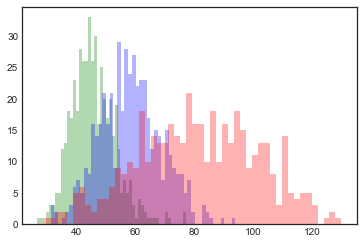

In [61]:
# create a histogram comparing Construction Managers and Sales Managers mean hourly wages
# across all metropolitan areas

# pass select arguments to plot
kwargs = dict(histtype = 'stepfilled', alpha = 0.3, bins = 50)

# create plot with two histograms
plt.hist(con['value'], **kwargs, color = 'green')
plt.hist(sal['value'], **kwargs, color = 'blue')
plt.hist(ceo['value'], **kwargs, color = 'red');

## Exploring specific datatypes

### `Hourly mean wage`

In [54]:
# "Hourly mean wage" in metro areas
hourly = oes_data_final.query('areatype_name == "Metropolitan or nonmetropolitan area"\
                                and datatype_name == "Hourly mean wage"')

hourly.head()

,occupation_name,industry_name,sector_name,areatype_name,area_name,state_name,datatype_name,value,series_title,release_date,seasonal_text,footnote_text,occupation_display_level,occupation_sort_sequence,industry_display_level,industry_sort_sequence
2,All Occupations,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Hourly mean wage,20.08,Hourly mean wage for All Occupations in All In...,May 2019,Not Seasonally Adjusted,NaN,0,0,0,0
19,Management Occupations,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Hourly mean wage,43.51,Hourly mean wage for Management Occupations in...,May 2019,Not Seasonally Adjusted,NaN,0,1,0,0
36,General and Operations Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Hourly mean wage,40.39,Hourly mean wage for General and Operations Ma...,May 2019,Not Seasonally Adjusted,NaN,3,4,0,0
53,Sales Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Hourly mean wage,59.96,Hourly mean wage for Sales Managers in All Ind...,May 2019,Not Seasonally Adjusted,NaN,3,10,0,0
70,Public Relations and Fundraising Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Hourly mean wage,NaN,Hourly mean wage for Public Relations and Fund...,May 2019,Not Seasonally Adjusted,Estimate not released.,2,11,0,0


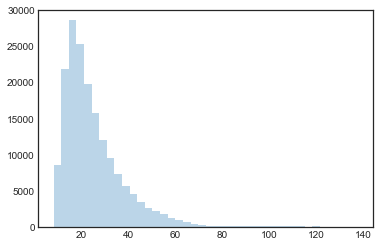

In [55]:
# show hist
plt.hist(hourly['value'], **kwargs);

In [56]:
# print NAs for hourly['value']
print(hourly['value'].isna().sum())

# and describe hourly mean wage
hourly['value'].describe()

12549


count    176245.000000
mean         25.758436
std          14.853465
min           8.130000
25%          16.190000
50%          21.640000
75%          30.780000
max         137.870000
Name: value, dtype: float64

### `Annual mean wage`

In [57]:
# "Annual mean wage" in metro areas
annual = oes_data_final.query('areatype_name == "Metropolitan or nonmetropolitan area"\
                                and datatype_name == "Annual mean wage"')

annual.head()

,occupation_name,industry_name,sector_name,areatype_name,area_name,state_name,datatype_name,value,series_title,release_date,seasonal_text,footnote_text,occupation_display_level,occupation_sort_sequence,industry_display_level,industry_sort_sequence
3,All Occupations,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Annual mean wage,41760.0,Annual mean wage for All Occupations in All In...,May 2019,Not Seasonally Adjusted,NaN,0,0,0,0
20,Management Occupations,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Annual mean wage,90500.0,Annual mean wage for Management Occupations in...,May 2019,Not Seasonally Adjusted,NaN,0,1,0,0
37,General and Operations Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Annual mean wage,84000.0,Annual mean wage for General and Operations Ma...,May 2019,Not Seasonally Adjusted,NaN,3,4,0,0
54,Sales Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Annual mean wage,124710.0,Annual mean wage for Sales Managers in All Ind...,May 2019,Not Seasonally Adjusted,NaN,3,10,0,0
71,Public Relations and Fundraising Managers,"Cross-industry, Private, Federal, State, and L...","Sector 00 - Cross-industry, Private, Federal, ...",Metropolitan or nonmetropolitan area,"Abilene, TX",Texas,Annual mean wage,NaN,Annual mean wage for Public Relations and Fund...,May 2019,Not Seasonally Adjusted,Estimate not released.,2,11,0,0


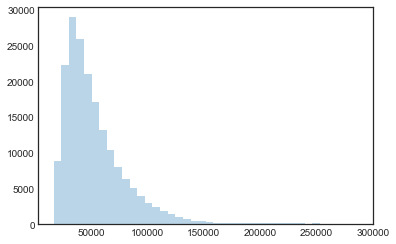

In [58]:
# show hist
plt.hist(annual['value'], **kwargs);

In [59]:
# print NAs for hourly['value']
print(annual['value'].isna().sum())

# and describe hourly mean wage
annual['value'].describe()

3590


count    185204.000000
mean      54098.891493
std       30727.376011
min       16920.000000
25%       34020.000000
50%       45860.000000
75%       65030.000000
max      286770.000000
Name: value, dtype: float64

In [60]:
# END